In [51]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

import ellipses as el
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()


In [52]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [69]:
data_pd = pd.read_csv('../Sims/test/cases_vaxvar0.25_popvar0.01_pop100000.0_0.csv',\
                      delim_whitespace=True,header=0)

In [126]:
#Normalization stuff.
#It *does* need to happen if you're using the area as the metric. Also, using the maximum in each year starting
#at January doesn't work - because the peak is different at different times. Amalies uses the maximum within a one
#year sliding window, so maybe that's better?

Idata = data_pd.values.copy()
Idata_norm = np.zeros(shape=np.shape(Idata))
nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
dates = np.linspace(0,nobs-1,nobs) 
dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
theta = 2.*np.pi*((dates+1)/24.)
#For each year, divide by the maximum outbreak size in that year.
#looped over patches, p
for p in range(400):
    nhigh = 0
    maxI = []
    i = 0
    j = 0
    for d in dates:
        if d ==0:
            nhigh = 0
        else:
            if Idata[i,p] > nhigh:
                nhigh = Idata[i,p]
        if d ==23:
            maxI.append(nhigh)
        i += 1
        
    year = 0
    k = 0
    for d in dates:
        '''
        #This does the maximum case count in a calendar year
        if d==0:
            nhigh = maxI[year]
            year += 1
            #print year, nhigh
        #print 'nhigh:',nhigh
        if nhigh==0.:
            nhigh += 1.
        '''
        if k<12:
            nhigh = np.max(Idata[0:k+12,p])
        elif k>1200-12:
            nhigh = np.max(Idata[k-12:,p])
        else:
            nhigh = np.max(Idata[k-12:k+12,p])
        if nhigh==0.:
            nhigh += 1.
        #nhigh = float(nhigh)
        #print Idata[k,0]
        Idata_norm[k,p] = Idata[k,p]/float(nhigh)
        k += 1
    



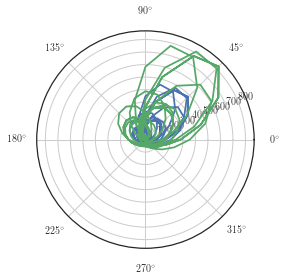

In [140]:
istart = 300
#plt.polar(theta[istart:],Idata[istart:,1]);
plt.polar(theta[istart:],Idata[istart:,0]);
plt.polar(theta[istart:],Idata[istart:,50]);
#plt.polar(theta[istart:],Idata[istart:,2]);
#plt.polar(theta[istart:],Idata[istart:,10]);
#plt.polar(theta[istart:],Idata[istart:,200]);
#plt.polar(theta[istart:],Idata[istart:,399]);

In [136]:
ratio = []
for i in range(400):
    thetafit = theta[istart:]
    Ifit = Idata_norm[istart:,i]
    cartcoords = pol2cart(Ifit,thetafit)
    data = cartcoords

    lsqe = el.LSqEllipse()
    lsqe.fit(data)
    center, width, height, phi = lsqe.parameters()
    
    '''
    #Plotting stuff
    plt.close('all')
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.plot(data[0], data[1], 'ro', label='test data', zorder=1)

    ellipse = Ellipse(xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
                   edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
    ax.add_patch(ellipse)

    plt.legend()
    plt.show()
    '''
    #if height>width:
        #print width, height,i
    if height>width:
        ratio.append(height/width)
    if width>=height:
        ratio.append(width/height)
    

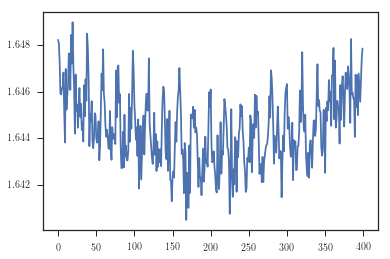

In [137]:
plt.plot(ratio)

In [138]:
print np.mean(ratio)

1.64446191987


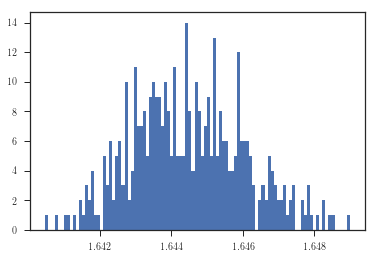

In [139]:
a,b,c = plt.hist(ratio,bins=100)

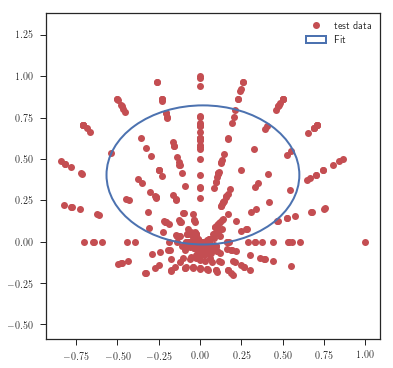

In [123]:


#data = el.make_test_ellipse()
#print np.shape(data)
thetafit = theta[istart:]
Ifit = Idata_norm[istart:,0]
cartcoords = pol2cart(Ifit,thetafit)
data = cartcoords

lsqe = el.LSqEllipse()
lsqe.fit(data)
center, width, height, phi = lsqe.parameters()

plt.close('all')
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('equal')
ax.plot(data[0], data[1], 'ro', label='test data', zorder=1)

ellipse = Ellipse(xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
               edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
ax.add_patch(ellipse)

plt.legend()
plt.show()

In [125]:
print width, height
print np.sqrt(1.-(height/width)**2)

0.5837303833 0.421012043929
0.692681076893


In [ ]:
#What about: xwidth = var(x), ywidth = var(y)